# Terry Stops
## Overview
In Terry v. OhioLinks to an external site., a landmark Supreme Court case in 1967-8, the court found that a police officer was not in violation of the "unreasonable search and seizure" clause of the Fourth Amendment, even though he stopped and frisked a couple of suspects only because their behavior was suspicious. Thus was born the notion of "reasonable suspicion", according to which an agent of the police may e.g. temporarily detain a person, even in the absence of clearer evidence that would be required for full-blown arrests etc. Terry Stops are stops made of suspicious drivers.

## Problem Statement

This project aims to build a model that can accurately predict the result of a Terry Stop i.e Arrest or No Arrest.
By applying the features from the dataset, this model will learn patterns and relationships that will help to differentiate those two outcomes.

## Objective

Build a model that will classify or predict whether an arrest was made or not after a Terry Stop conducted by law enforcement officers.

## Methodology
1. `Data Exploration` : Examine the data structure and content, identify relevant variables and understand their meaning and distribution.

2. `Analysis` : Generate descriptive statistics and visualizations to gain insight into the patterns of Terry stops.

3. `Predictive Modeling` : Create models that will predict whether an arrest was made after a Terry stop.
 

## Data Understanding
The dataset contains various attributes related to the stops, including demographic information, stop location, stop reasoning, and outcomes.
his data represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop.

- Each record contains perceived demographics of the subject, as reported by the officer making the stop and officer demographics as reported to the Seattle Police Department, for employment purposes.
### Data description

`Subject Age Group`: Subject Age Group (10 year increments) as reported by the officer.

`Subject ID`: Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last name. "Null" values indicate an "anonymous" or "unidentified" subject. 

`GO / SC Num`: General Offense or Street Check number, relating the Terry Stop to the parent report. This field may have a one to many relationship in the data.

`Terry Stop ID`: Key identifying unique Terry Stop reports.

`Stop Resolution`: Resolution of the stop as reported by the officer.

`Weapon Type`: Type of weapon, if any, identified during a search or frisk of the subject. Indicates "None" if no weapons was found.

`Officer ID`: Key identifying unique officers in the dataset.

`Officer YOB`: Year of birth, as reported by the officer.

`Officer Gender`: Gender of the officer, as reported by the officer.

`Officer Race`: Race of the officer, as reported by the officer.

`Subject Perceived Race`: Perceived race of the subject, as reported by the officer.

`Subject Perceived Gender`: Perceived gender of the subject, as reported by the officer.

`Reported Date`: Date the report was filed in the Records Management System (RMS). Not necessarily the date the stop occurred but generally within 1 day.

`Reported Time`: Time the stop was reported in the Records Management System (RMS). Not the time the stop occurred but generally within 10 hours.

`Initial Call Type`: Initial classification of the call as assigned by 911.

`Final Call Type`: Final classification of the call as assigned by the primary officer closing the event.

`Call Type`: How the call was received by the communication center.

`Officer Squad`: Functional squad assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP).

`Arrest Flag`: Indicator of whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS).

`Frisk Flag`: Indicator of whether a "frisk" was conducted, by the officer, of the subject, during the Terry Stop.

`Precinct`: Precinct of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

`Sector`: Sector of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.

`Beat`: Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.


In [5]:
# importing libraries
from imports.functions import *
%matplotlib inline

In [8]:
# creating a dataframe
df = pd.read_csv('data/Terry_Stops.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,36 - 45,7726342469,20200000112069,12803715000,Field Contact,-,6953,1968,M,White,...,19:28:18.0000000,"DISTURBANCE, MISCELLANEOUS/OTHER",--DISTURBANCE - OTHER,911,NaN,N,N,North,N,N2
1,46 - 55,17544297314,20210000007572,19456101086,Field Contact,-,6678,1970,M,White,...,06:01:35.0000000,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,NaN,N,N,North,U,U2
2,26 - 35,-1,20150000005079,88327,Field Contact,None,6382,1958,M,Nat Hawaiian/Oth Pac Islander,...,16:14:00.0000000,-,-,-,NORTH PCT 2ND W - JOHN - PLATOON 1,N,N,-,-,-
3,-,31307974123,20220000015393,31308022368,Field Contact,-,6799,1976,M,Hispanic or Latino,...,13:34:08.0000000,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NaN,N,N,West,M,M3
4,26 - 35,7727242683,20190000195849,8258954520,Field Contact,-,6953,1968,M,White,...,16:06:48.0000000,"SUSPICIOUS PERSON, VEHICLE OR INCIDENT",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NaN,N,N,North,N,N3


In [4]:
# checking data details
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
17,Officer Squad,38.8,930838,2399030,object
0,Subject Age Group,0.0,0,2399030,object
12,Reported Date,0.0,0,2399030,object
21,Sector,0.0,0,2399030,object
20,Precinct,0.0,0,2399030,object
19,Frisk Flag,0.0,0,2399030,object
18,Arrest Flag,0.0,0,2399030,object
16,Call Type,0.0,0,2399030,object
15,Final Call Type,0.0,0,2399030,object
14,Initial Call Type,0.0,0,2399030,object


- `Officer Squad` has about 38.8 percent of missing data which translates to 930838 rows. From the total number of rows available and what the data in this squad signifies, I'll drop just the missing rows since the remaining data is sufficient.


In [5]:
# dropping null values
df.dropna(inplace=True)

In [6]:
# investigating the Beat column
df.Beat.value_counts()

-     383904
N3     50482
E2     45107
K3     40807
M2     36593
M3     33927
N2     30358
E1     30014
R2     28810
B1     27606
U2     27262
M1     26918
F2     26574
K2     25843
B2     25069
D1     24725
L1     24467
L3     23005
L2     23005
S2     22747
D2     22747
E3     21414
O1     21070
S3     20812
K1     19135
Q3     19135
J1     19049
B3     18490
F3     17888
U1     17587
G2     17544
R1     17458
D3     17329
W2     16426
R3     16297
J3     16168
G3     16125
C3     15394
C1     15351
O2     14663
S1     14190
F1     14147
O3     14104
W1     14018
Q2     13416
N1     13244
J2     12857
C2     11739
G1     11180
U3     11094
W3      9804
Q1      8729
99      2279
S         86
Name: Beat, dtype: int64

It has `-` as the most occuring value, I'll change that to `unknown`

In [9]:
# replacing values
df.replace({'Frisk Flag': '-', 'Subject Perceived Gender': '-', 'Subject Perceived Race': '-', 
            'Subject Age Group': '-', 'Call Type': '-', 'Precinct': '-', 'Weapon Type': '-',
            'Beat':'-', 'Final Call Type':'-'}, 'Unknown', inplace=True)


In [10]:
# the column for officer year of birth will be dropped and instead will use age
# I'll use the reporting date to calculate the age at the time of reporting
# Convert strings to datetime objects

df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df['Officer YOB'] = pd.to_numeric(df['Officer YOB'], errors='coerce')

df['age'] = df['Reported Date'].dt.year - df['Officer YOB']

# EDA

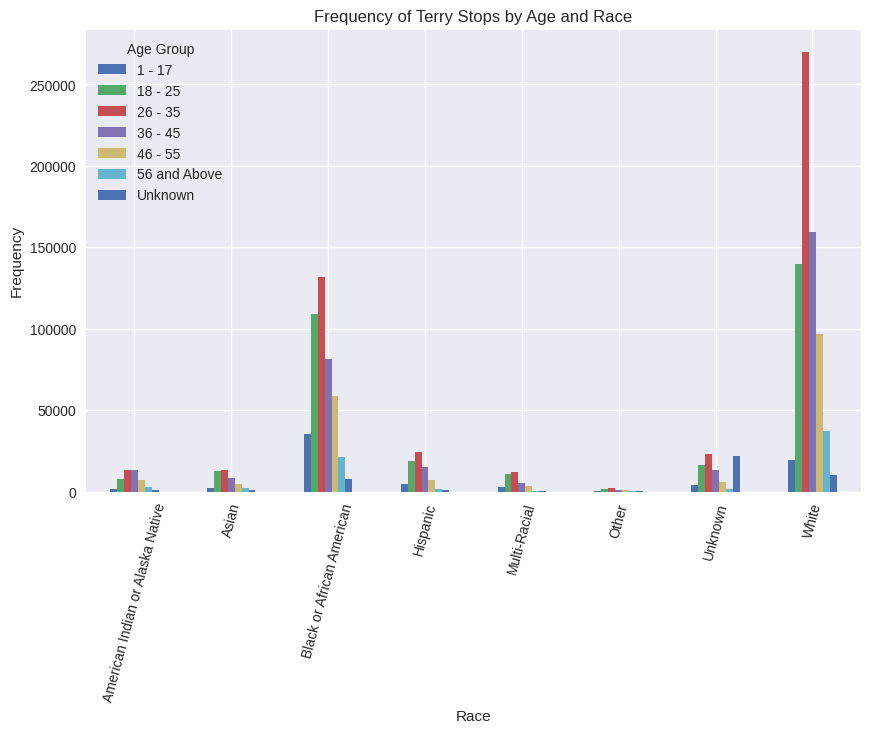

In [11]:
# subset the data 
new_df = df[['Subject Perceived Race','Subject Age Group']]

# group the DataFrame
grouped_df = df.groupby(['Subject Perceived Race', 'Subject Age Group']).size().unstack()

# plotting the bar chart
grouped_df.plot(kind='bar', figsize=(10, 6))

plt.title('Frequency of Terry Stops by Age and Race')
plt.xlabel('Race')
plt.ylabel('Frequency')
plt.xticks(rotation=75)
plt.legend(title='Age Group')
plt.show()

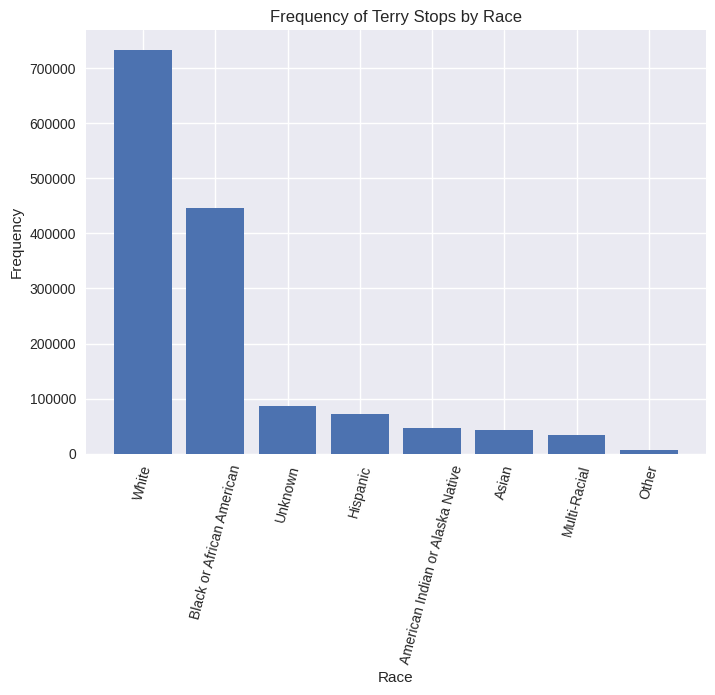

In [13]:
# calculate the count of each race in the 'Subject Perceived Race' column
race_counts = df['Subject Perceived Race'].value_counts()

# plot a bar chart using the race counts
plt.bar(race_counts.index, race_counts.values)

# set the title, x-label, and y-label for the chart
plt.title('Frequency of Terry Stops by Race')
plt.xlabel('Race')
plt.ylabel('Frequency')

# rotate the x-axis tick labels for better readability
plt.xticks(rotation=75)

# display the chart
plt.show()


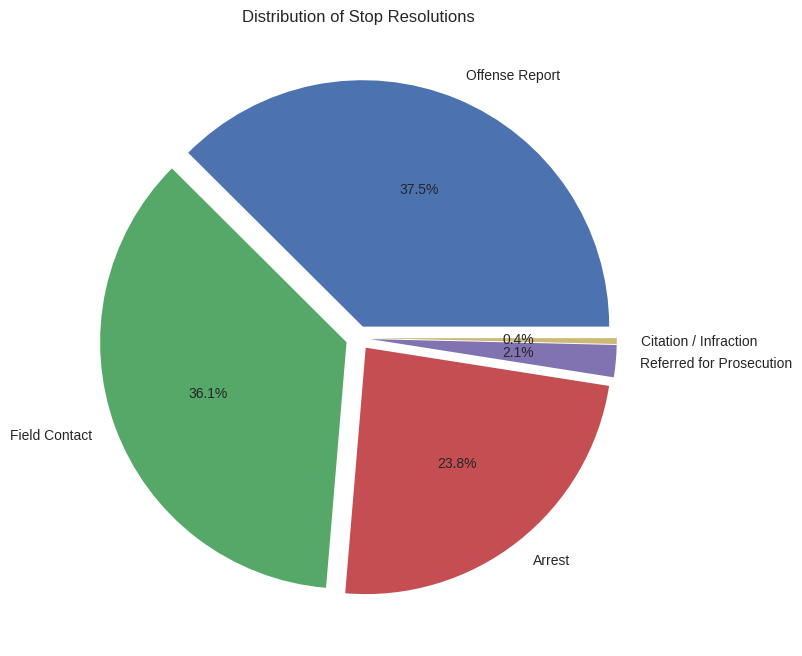

In [14]:
# calculate the count of each stop resolution in the 'Stop Resolution' column
stop_resolution_counts = df['Stop Resolution'].value_counts()

# define the extent to which each pie slice is separated from the center
explode = [0.05, 0.05, 0.05, 0.05, 0.05]  

plt.figure(figsize=(8, 8))

# generate a pie chart using the stop resolution counts
plt.pie(stop_resolution_counts, labels=stop_resolution_counts.index, autopct='%1.1f%%', explode=explode)

# set the title of the pie chart
plt.title('Distribution of Stop Resolutions')

# display the chart
plt.show()


# Feature Engineering

Some of the columns contain data that is not useful as it is. I'll use various techniques to create new features and drop the original columns.

In [15]:
# investigating age column
print(f"Youngest: {df['age'].min()}")
print(f"Oldest: {df['age'].max()}")

Youngest: 21
Oldest: 119


Given that in Seattle the minimum age to enroll at the time of this project is 20.5 years and the retirement age is 65, we will drop any above 65 by the time of the stop.

In [16]:
# dropping officers who were above 65 or below 21 by the time of the stop
df = df[(df['age'] <= 65) & (df['age'] >= 21)]


In [17]:
# investigating age column
print(f"Youngest: {df['age'].min()}")
print(f"Oldest: {df['age'].max()}")

Youngest: 21
Oldest: 65


In the `weapon type` column, there are different types that can be grouped together.

In [18]:
# getting count of weapons
df['Weapon Type'].value_counts()

None                               1383611
Lethal Cutting Instrument            62952
Handgun                               9804
Firearm Other                         4257
Unknown                               2623
Club, Blackjack, Brass Knuckles       2107
Firearm (unk type)                     645
Club                                   387
Rifle                                  172
Shotgun                                129
Automatic Handgun                       86
Blackjack                               43
Brass Knuckles                          43
Name: Weapon Type, dtype: int64

In [19]:
# replace some values in the 'Weapon Type' column with 'Firearm'
df.replace({'Weapon Type': ['Handgun', 'Firearm Other', 'Firearm (unk type)', 'Other Firearm',
                            'Rifle', 'Shotgun', 'Automatic Handgun']}, 'Firearm', inplace=True)

# replace some values in the 'Weapon Type' column with 'Striking Object'
df.replace({'Weapon Type': ['Club, Blackjack, Brass Knuckles', 'Blackjack', 'Brass Knuckles',
                            'Club', 'Personal Weapons (hands, feet, etc.)']}, 'Striking Object', inplace=True)



In [20]:
# cols to drop
cols = ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer YOB', 'Initial Call Type', 
        'Arrest Flag', 'Reported Date', 'Sector', 'Officer ID', 'Beat']

# drop the specified columns from the DataFrame
drop(df, cols)


Number of columns before dropping: 24
Number of columns after dropping: 14


In [21]:
# change data type
df['Reported Time'] = df['Reported Time'].astype('str')

# extract the first 5 characters
df['Reported Time'] = df['Reported Time'].str[:5]


In [22]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Final Call Type,Call Type,Officer Squad,Frisk Flag,Precinct,age
2,26 - 35,Field Contact,None,M,Nat Hawaiian/Oth Pac Islander,White,Male,16:14,Unknown,Unknown,NORTH PCT 2ND W - JOHN - PLATOON 1,N,Unknown,57
6,26 - 35,Field Contact,None,M,White,White,Male,16:56,Unknown,Unknown,WEST PCT 2ND W - D/M RELIEF,N,Unknown,33
7,56 and Above,Offense Report,None,M,White,White,Male,17:38,--DV - ASSIST VICTIM BY COURT ORDER,911,SOUTH PCT 2ND W - ROBERT - PLATOON 2,N,South,27
9,26 - 35,Offense Report,None,M,Hispanic or Latino,White,Male,00:52,"--ASSAULTS, OTHER",ONVIEW,EAST PCT 2ND W - CHARLIE RELIEF,N,East,28
10,18 - 25,Offense Report,Lethal Cutting Instrument,M,Hispanic or Latino,White,Male,02:34,--DISTURBANCE - OTHER,911,EAST PCT 3RD W - E/G RELIEF,Y,East,26


In [23]:
df['Stop Resolution'].unique()

array(['Field Contact', 'Offense Report', 'Arrest',
       'Citation / Infraction', 'Referred for Prosecution'], dtype=object)

The target column can then be engineered to contain binary according to the outcome of the stop.
From the above cell, there are 5 different outcomes, I'll combine them according to the severity of the outcome
- `1` means `Arrest` while `0` means `No Arrest`.

In [40]:
# Replace some values in the 'Stop Resolution' column with 0
df.replace({'Stop Resolution': ['Field Contact', 'Citation / Infraction', 'Offense Report']}, 0, inplace=True)

# Replace some values in the 'Stop Resolution' column with 1
df.replace({'Stop Resolution': ['Arrest', 'Referred for Prosecution']}, 1, inplace=True)


In [25]:
# removing minutes in time by rounding to the next hour
df['Reported Time'] = df['Reported Time'].apply(round_time)


In [26]:
df['Subject Age Group'].unique()

array(['26 - 35', '56 and Above', '18 - 25', '46 - 55', 'Unknown',
       '36 - 45', '1 - 17'], dtype=object)

Using the age groups in subjects, I will create similar groups for the police.

In [27]:
# Create a new column 'Officer Age Group' by applying the function 'map_age' to the 'age' column
df['Officer Age Group'] = df['age'].apply(map_age)

# Drop the 'age' column from the DataFrame
df.drop('age', axis=1, inplace=True)

# Apply the function 'map_time' to the 'Reported Time' column
df['Reported Time'] = df['Reported Time'].apply(map_time)

# Apply the function 'call_group' to the 'Final Call Type' column
df['Final Call Type'] = df['Final Call Type'].apply(call_group)

# Apply the function 'squad_groups' to the 'Officer Squad' column
df['Officer Squad'] = df['Officer Squad'].apply(squad_groups)


In [28]:
info(df)

,Column,Missing Percentage,Missing Values,Length,Data type
0,Subject Age Group,0.0,0,1466859,object
1,Stop Resolution,0.0,0,1466859,object
2,Weapon Type,0.0,0,1466859,object
3,Officer Gender,0.0,0,1466859,object
4,Officer Race,0.0,0,1466859,object
5,Subject Perceived Race,0.0,0,1466859,object
6,Subject Perceived Gender,0.0,0,1466859,object
7,Reported Time,0.0,0,1466859,object
8,Final Call Type,0.0,0,1466859,object
9,Call Type,0.0,0,1466859,object


In [41]:
df.head()

,Subject Age Group,Stop Resolution,Weapon Type,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Time,Final Call Type,Call Type,Officer Squad,Frisk Flag,Precinct,Officer Age Group
2,26 - 35,0,None,M,Nat Hawaiian/Oth Pac Islander,White,Male,Afternoon,Unknown,Unknown,NORTH PCT,N,Unknown,56 and Above
6,26 - 35,0,None,M,White,White,Male,Afternoon,Unknown,Unknown,WEST PCT,N,Unknown,26 - 35
7,56 and Above,0,None,M,White,White,Male,Afternoon,Domestic_Violence,911,SOUTH PCT,N,South,26 - 35
9,26 - 35,0,None,M,Hispanic or Latino,White,Male,After Midnight,Assault,ONVIEW,EAST PCT,N,East,26 - 35
10,18 - 25,0,Lethal Cutting Instrument,M,Hispanic or Latino,White,Male,After Midnight,Disturbances,911,EAST PCT,Y,East,26 - 35


# Modelling

In [42]:
# separate data into features and target
X = df.drop('Stop Resolution', axis=1)
y = df['Stop Resolution']

The target variable and the features are separated.

`Precision` will be used as the classification metric for the models. In this project, precision will represent the ratio of correctly predicted arrests after a stop to the instances predicted as arrests by the model.<br>
High precision will indicate that the model might be highly reliable and accurate. A good precision score for the models will indicate a high level of accuracy in predicting actual arrests.

## Splitting the data

Split into train and test data.
- `X_train_second` and `y_train_second` will be used for training.
- `X_test_second` and `y_test_second` will be used for validation.
- `X_test_first` and `y_test_first` will be for the final evaluation of the model on unseen data.

In [43]:
df.shape

(1466859, 14)

In [44]:
# first split
X_train_first, X_test_first, y_train_first, y_test_first = train_test_split(X, y, test_size=0.2, random_state=33)

In [46]:
print(f'Shape of X_train: {X_train_first.shape}')
print('=========================================')
print(f'Shape of y_train: {y_train_first.shape}')

Shape of X_train: (1173487, 13)
Shape of y_train: (1173487,)


In [47]:
# second split
X_train_second, X_test_second, y_train_second, y_test_second = train_test_split(X_train_first, y_train_first, test_size=0.2, random_state=33)

In [48]:
print(f'Shape of X_train: {X_train_second.shape}')
print('=========================================')
print(f'Shape of y_train: {y_train_second.shape}')

Shape of X_train: (938789, 13)
Shape of y_train: (938789,)


## Feature Encoding

In [49]:
# using OneHotEncoder to transform the columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_ohe = ohe.fit_transform(X_train_second)
X_test_ohe = ohe.transform(X_test_second)

# First Model - Logistic Regression
- This will be a baseline model.

In [50]:
# instantiating and fitting
logreg = LogisticRegression(random_state=42)

first_model = logreg.fit(X_train_ohe, y_train_second)

In [51]:
# generating predictions
y_hat_train1 = logreg.predict(X_train_ohe)
y_hat_test1 = logreg.predict(X_test_ohe)

In [52]:
# checking scores
calc_scores(y_train_second, y_hat_train1, y_test_second, y_hat_test1)

F1 score for training data: 0.6542253895220311
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.6544275927547738
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.6562231020829747
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.6574247656635421
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.652239803151531
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.6514576238043248


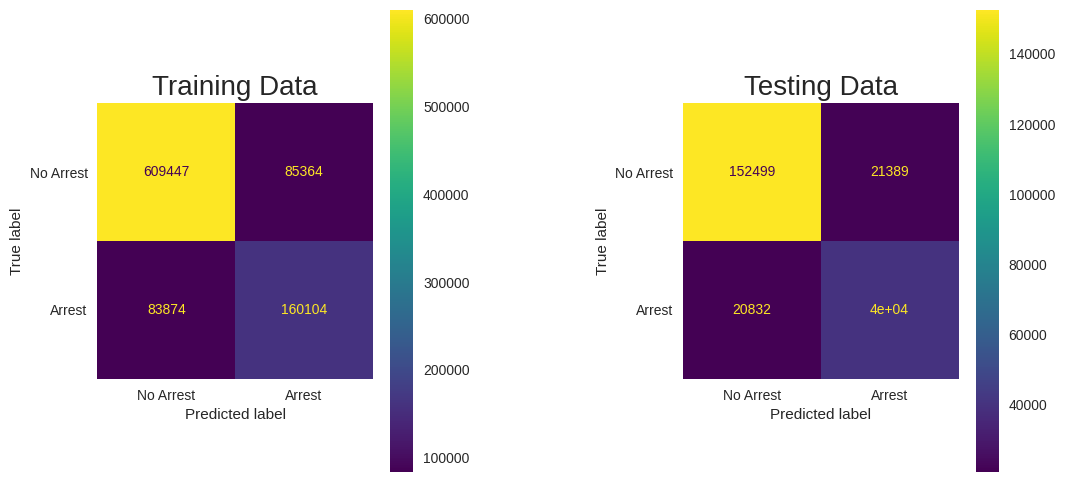

In [53]:
plot_cm(y_train_second, y_hat_train1, y_test_second, y_hat_test1)

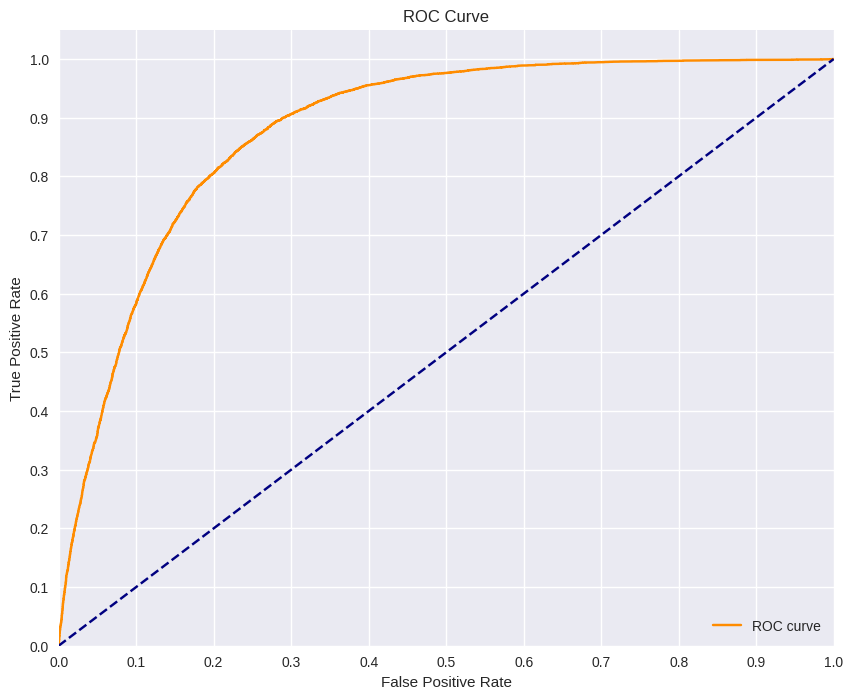

AUC: 0.8794


In [54]:
# plotting a ROC curve
plot_roc(X_train_ohe, y_train_second, X_test_ohe, y_test_second, logreg)

### Review
#### Given that we are using `Precision` as the metric to analyse the models, this model is not good as it only attains `0.65` precision. Our target is a serious issue thus a high precision is needed

- The `F1 Score` of `0.65` shows the average between recall and precision.<br>
- We can further see the `recall score` and `precision score` are `0.65`. <br>

- The confusion matrix shows that the model correctly predicts about `40000` as `Arrest` and `152499` as `Not arrest` using the test data.<br>
- Although there is still a big number that it predicts wrong





# Second Model - Decision Tree
Given the scores the first model produced, the second model should hopefully improve on that

In [61]:
# create an instance
dt = DecisionTreeClassifier()

# fit the model
second_model = dt.fit(X_train_ohe, y_train_second)


In [56]:
# predict the target variable for the training data
y_hat_train2 = dt.predict(X_train_ohe)

# predict the target variable for the testing data
y_hat_test2 = dt.predict(X_test_ohe)


In [57]:
calc_scores(y_train_second, y_hat_train2, y_test_second, y_hat_test2)

F1 score for training data: 0.9513050285314051
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9451324801506976
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9463804113485642
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9406018746916626
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9562811656146978
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9497069420691716


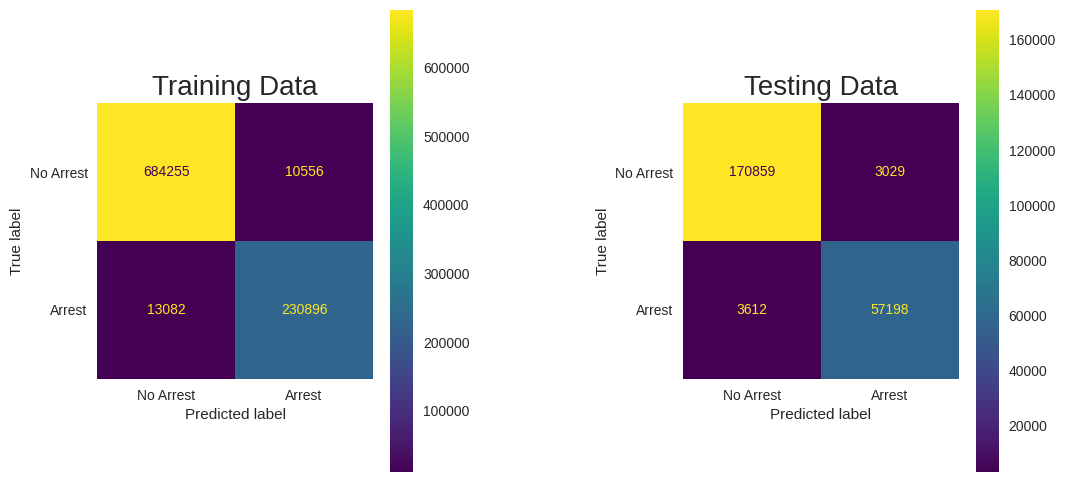

In [58]:
plot_cm(y_train_second, y_hat_train2, y_test_second, y_hat_test2)


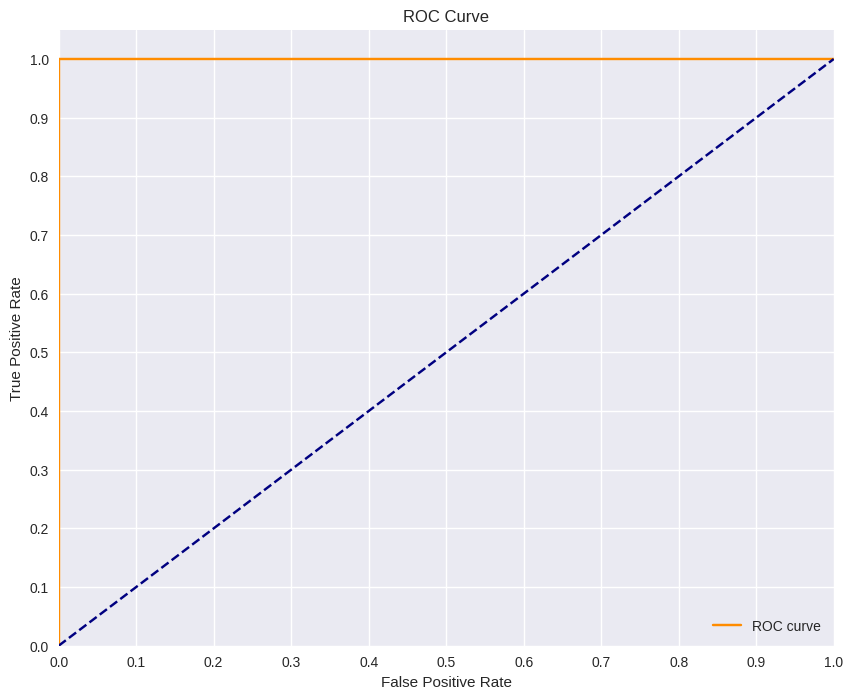

AUC: 1.0000


In [59]:
plot_roc(X_train_ohe, y_hat_train2, X_test_ohe, y_hat_test2, dt)

### Review
The metrics from the second model suggest an even better performance.<br>

The `Precision` score has improved massively reaching `0.95`. This is a good number considering the target though we can try to improve it further.<br>

Other models will be developed to test whether the `Precision` will improve.

# Third Model - Random Forest

In [62]:
# Create a new instance of the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Fit the model
third_model = rfc.fit(X_train_ohe, y_train_second)


In [63]:
# Predict the target variable for the training data
y_hat_train3 = rfc.predict(X_train_ohe)

# Predict the target variable for the testing data
y_hat_test3 = rfc.predict(X_test_ohe)



In [64]:
# calculate evaluation scores
calc_scores(y_train_second, y_hat_train3, y_test_second, y_hat_test3)

F1 score for training data: 0.9514108548162672
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9454089998928781
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9486675028076302
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9433645781943759
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9541701192640505
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9474623020133119


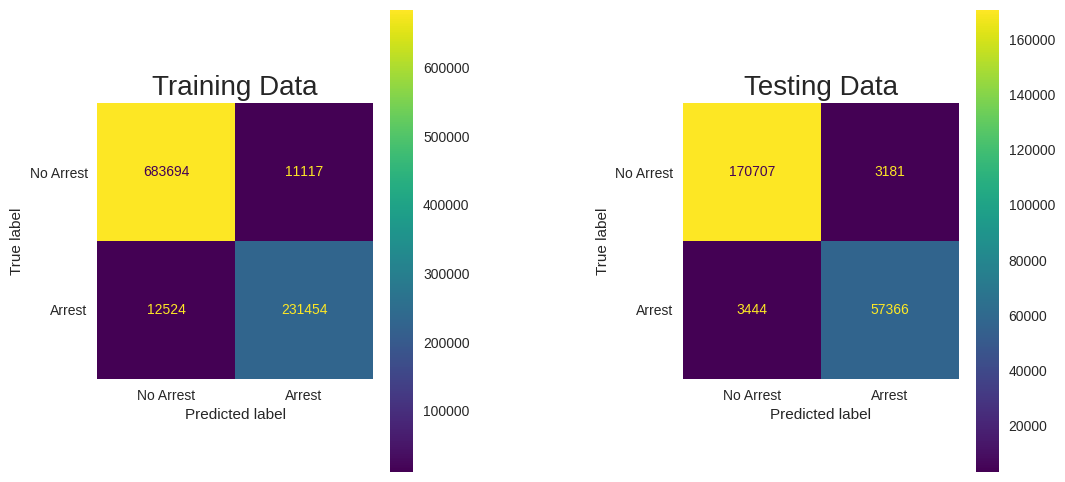

In [65]:
# plot confusion matrix
plot_cm(y_train_second, y_hat_train3, y_test_second, y_hat_test3)


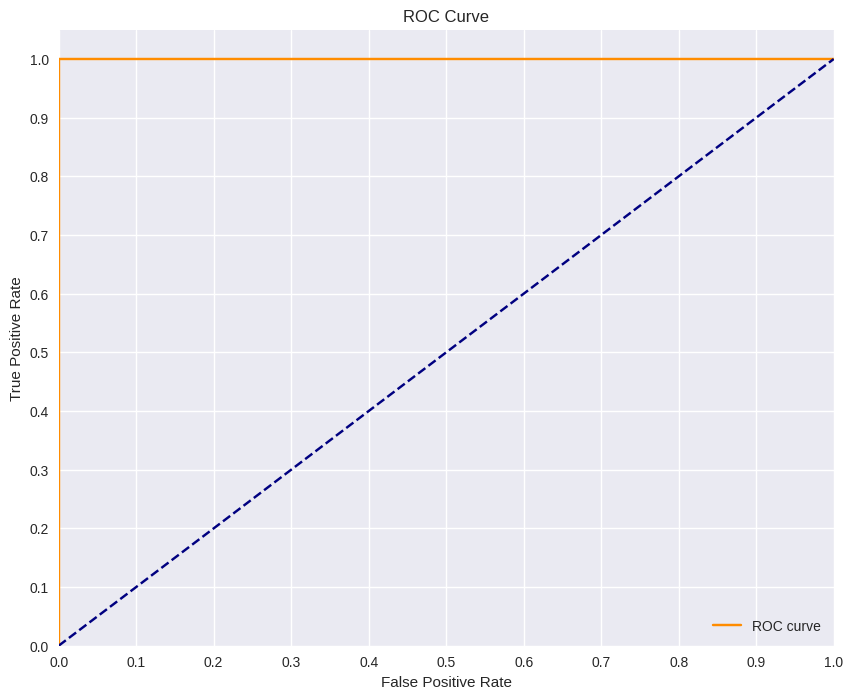

AUC: 1.0000


In [66]:
# plot roc curve
plot_roc(X_train_ohe, y_hat_train3, X_test_ohe, y_hat_test3, rfc)

### Review
The `Precision` score for this model drops which is not acceptable. This model is therefore not suitable even though some of the other metrics improved.

# Fourth Model - Using SMOTE
SMOTE will be applied to the features to generate balanced classes.

In [68]:
# applying smote to features
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_ohe, y_train_second)

In [69]:
# checking smote results
print(pd.Series(y_train_smote).value_counts())
print('==================')
print(X_train_smote.shape)

0    694811
1    694811
Name: Stop Resolution, dtype: int64
(1389622, 83)


In [70]:
# decision tree after smote
fourth_model = dt.fit(X_train_smote, y_train_smote)

In [71]:
# predictions
y_hat_train22 = dt.predict(X_train_smote)
y_hat_test22 = dt.predict(X_test_ohe)


In [72]:
# checking scores
calc_scores(y_train_smote, y_hat_train22, y_test_second, y_hat_test22)

F1 score for training data: 0.9777132612783751
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9432305556855222
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9940933577620389
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9945568163131064
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9618642179553595
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.8969419232366376


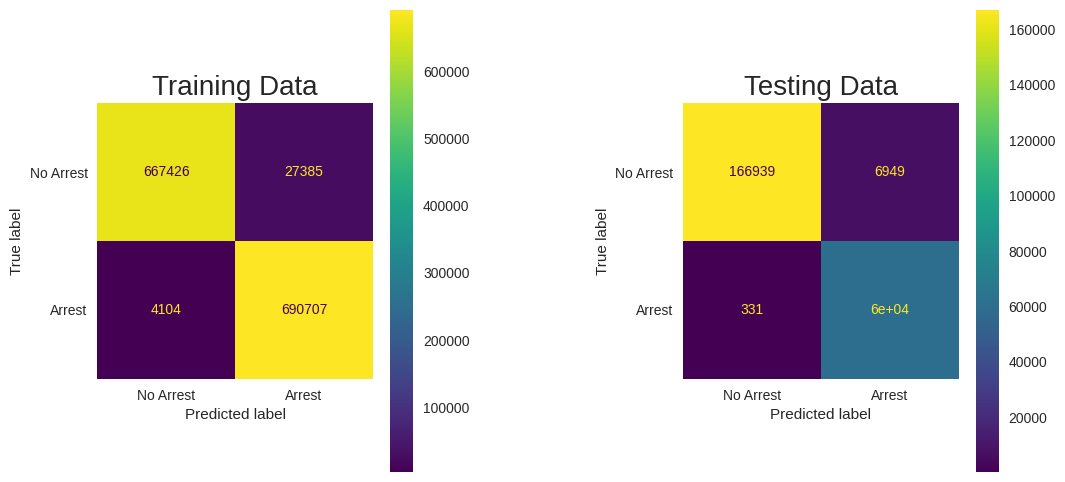

In [73]:
# plotting confusion matrix
plot_cm(y_train_smote, y_hat_train22, y_test_second, y_hat_test22)


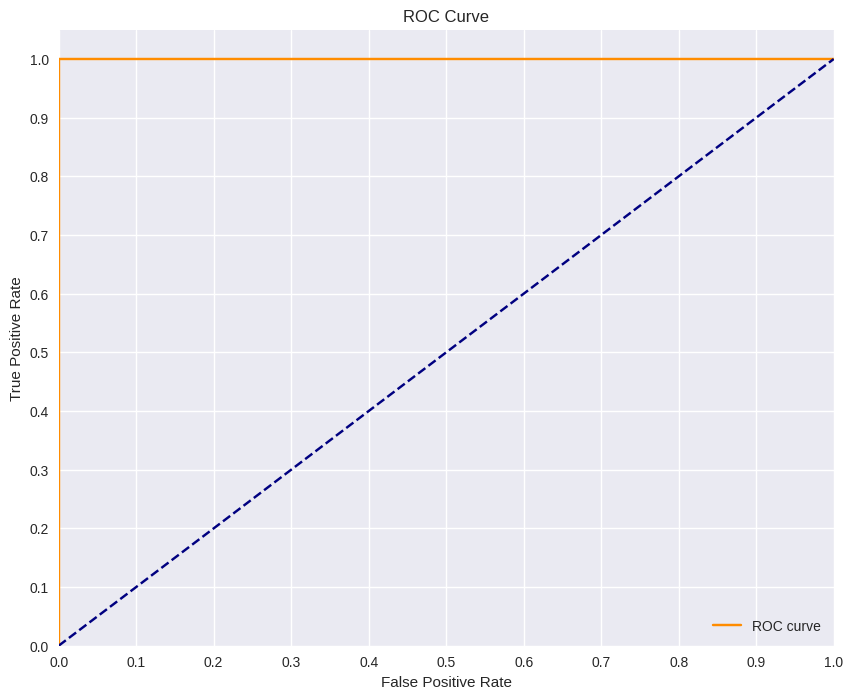

AUC: 1.0000


In [74]:
# plotting roc curve
plot_roc(X_train_smote, y_hat_train22, X_test_ohe, y_hat_test22, dt)

### Review
The `Precision` score is worse than that of the `Decision Tree` without smote. The model is not good for predicting our target.


#  Fifth Model - XGBoost


In [79]:
# Create a new instance of the XGBClassifier
xgb = XGBClassifier()

# Fit the XGBClassifier model
fifth_model = xgb.fit(X_train_ohe, y_train_second)

In [80]:
#Train Scores
train_preds = xgb.predict(X_train_ohe)

#Test Scores
test_preds = xgb.predict(X_test_ohe)

In [85]:
# checking scores
calc_scores(y_train_second, train_preds, y_test_second, test_preds)

F1 score for training data: 0.753985395454078
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.7504063229628164
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.7511947798572003
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.7478704160499918
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.7567968220933882
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.7529594860842067


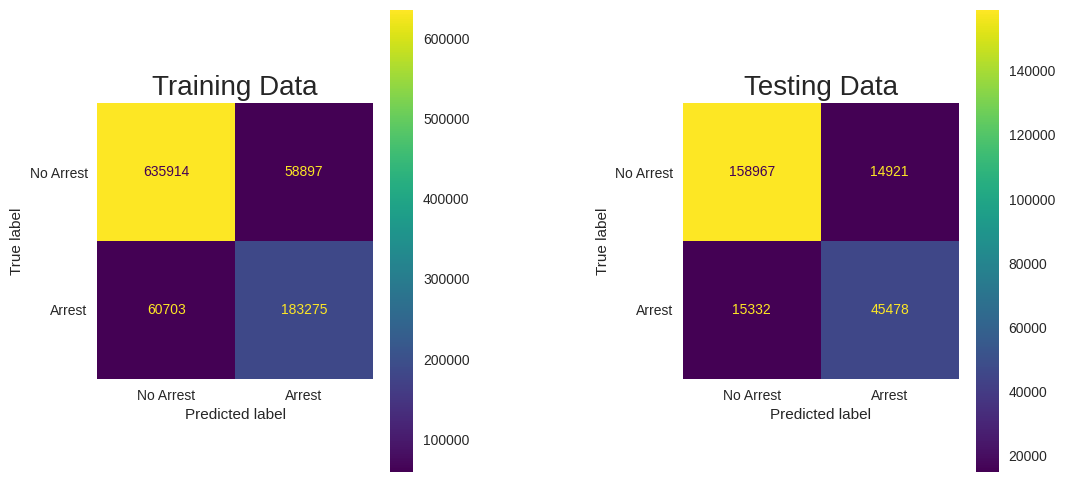

In [82]:
# plotting confusion matrix
plot_cm(y_train_second, train_preds, y_test_second, test_preds)


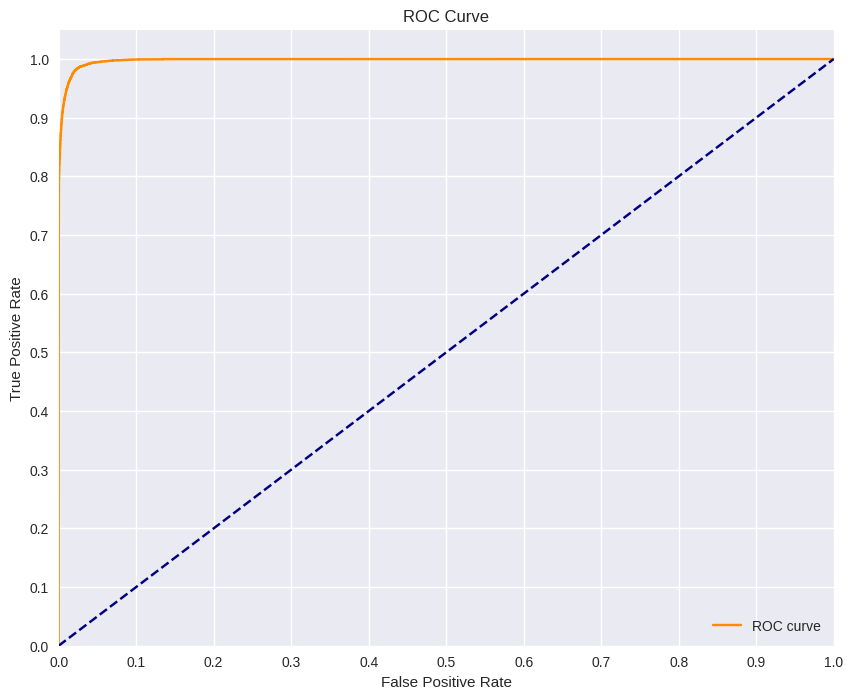

AUC: 0.9981


In [83]:
# plotting roc curve
plot_roc(X_train_ohe, train_preds, X_test_ohe, test_preds, xgb)

### Review
This model performs better than the `Logistic Regression` but its `Precision` is too low to be considered for predicting the target.

## Checking Cross_Val_Score

In [87]:
# List of classifiers
classifiers = [first_model, second_model, third_model, fourth_model, fifth_model]

# Perform cross-validation for each classifier
for clf in classifiers:
    scores = cross_val_score(clf, X_train_ohe, y_train_second, cv=3)
    mean_score = scores.mean()
    print(f"{clf.__class__.__name__} Mean Score: {mean_score}")

LogisticRegression Mean Score: 0.8194940499581982
DecisionTreeClassifier Mean Score: 0.9728575852399622
RandomForestClassifier Mean Score: 0.9728117815718736
DecisionTreeClassifier Mean Score: 0.9728575852399622
XGBClassifier Mean Score: 0.8720266206168147


The three model, `decision tree`, `random forest` and `decision tree with smote` perform very similarly.<br>
`Decision tree` will be considered for the final due to its less computation power and runtime.

# Final Model - Decision Tree
The model will use all the data from the train test split

In [88]:
# Create a pipeline consisting of two steps: OneHotEncoder and DecisionTreeClassifier
pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)),
                 ('tree', DecisionTreeClassifier())])


In [90]:
# Fit the pipeline (final_model) on the training data
final_model = pipe.fit(X_train_second, y_train_second)

# Print the final_model
final_model


Pipeline(steps=[('ohe',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False)),
                ('tree', DecisionTreeClassifier())])

In [91]:
# validation on the training data
final_preds_train = pipe.predict(X_train_second)
final_preds_test = pipe.predict(X_test_second)

In [93]:
# checking scores on training data
calc_scores(y_train_second, final_preds_train, y_test_second, final_preds_test)

F1 score for training data: 0.9513050285314051
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9451324801506976
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9463804113485642
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9406018746916626
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9562811656146978
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.9497069420691716


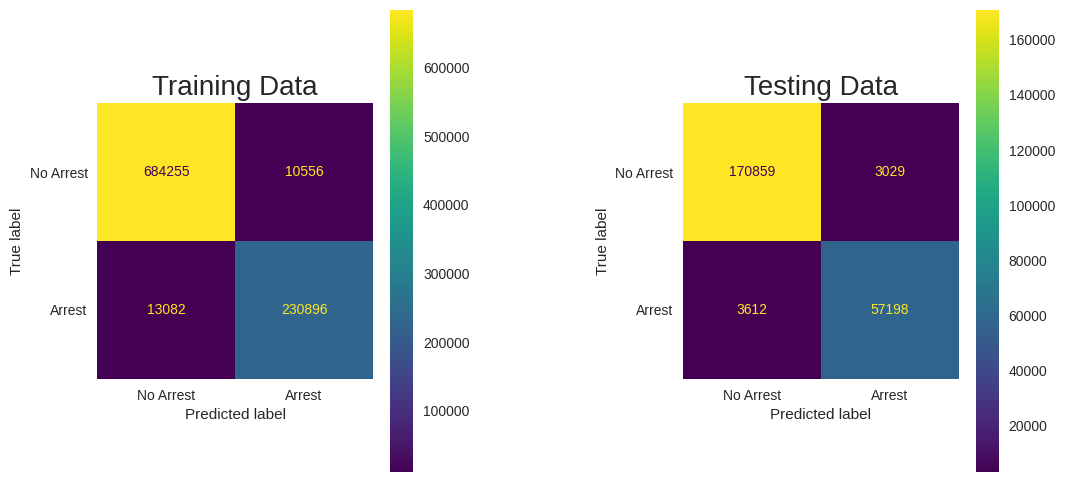

In [120]:
# plotting confusion matrix for training data
plot_cm(y_train_second, final_preds_train, y_test_second, final_preds_test)


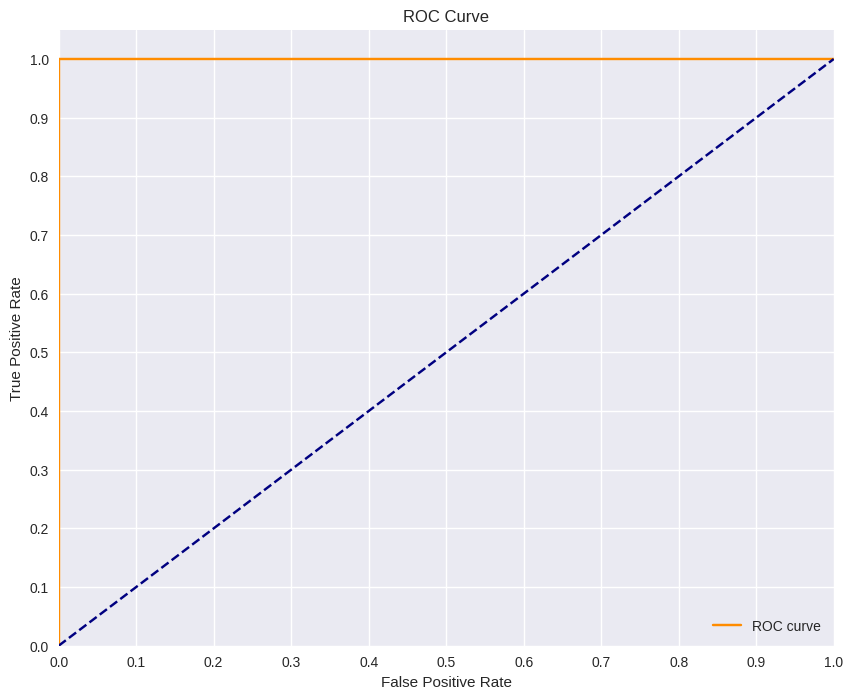

AUC: 1.0000


In [123]:
# plotting roc curve on training data
plot_roc(X_train_second, final_preds_train, X_test_second, final_preds_test, pipe)

Using the training data, the model produces great metrics indicating a good performance across all thresholds.

In [94]:
# validation on unseen data
unseen_preds_train = pipe.predict(X_train_first)
unseen_preds_test = pipe.predict(X_test_first)

In [99]:
# checking scores on validation set
calc_scores(y_train_first, unseen_preds_train, y_test_first, unseen_preds_test)

F1 score for training data: 0.9500731284637086
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
F1 score for testing data: 0.9474463752016714
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for training data: 0.9452275023951074
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Recall score for testing data: 0.9429695829000881
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for training data: 0.9549686918877349
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
Precision score for testing data: 0.951965877835209


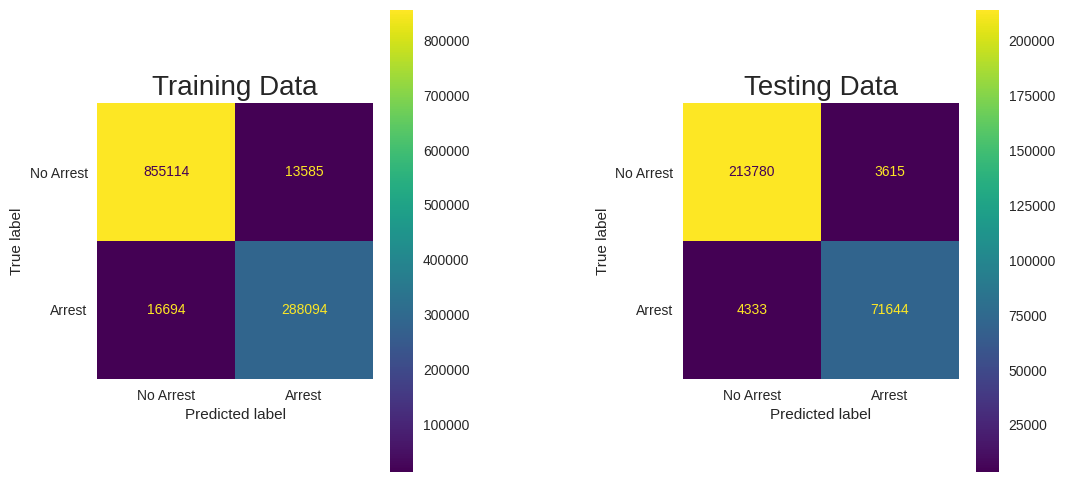

In [121]:
# plotting confusion matrix on validation data
plot_cm(y_train_first, unseen_preds_train, y_test_first, unseen_preds_test)


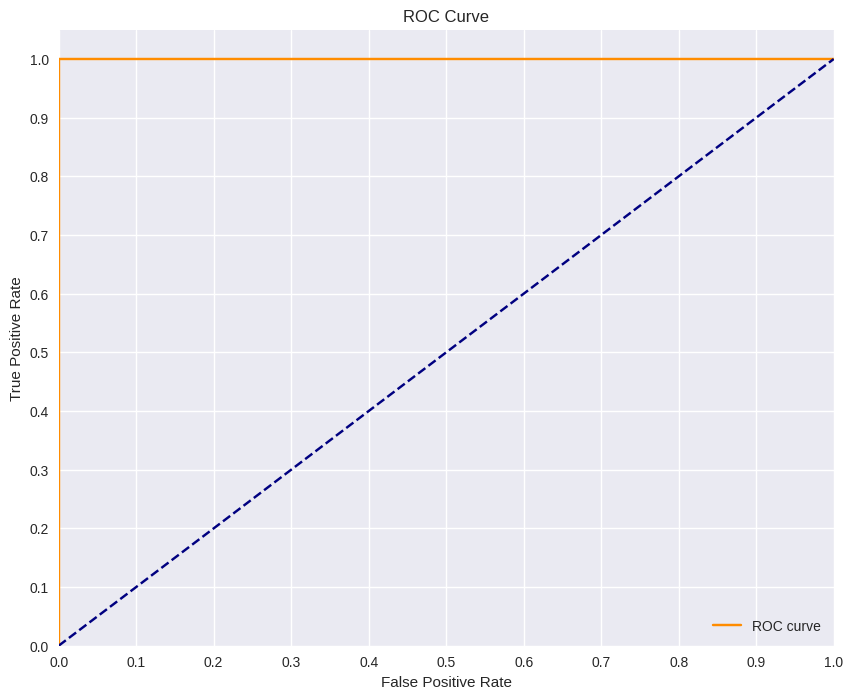

AUC: 1.0000


In [124]:
# plotting roc curve on validation data
plot_roc(X_train_first, unseen_preds_train, X_test_first, unseen_preds_test, pipe)

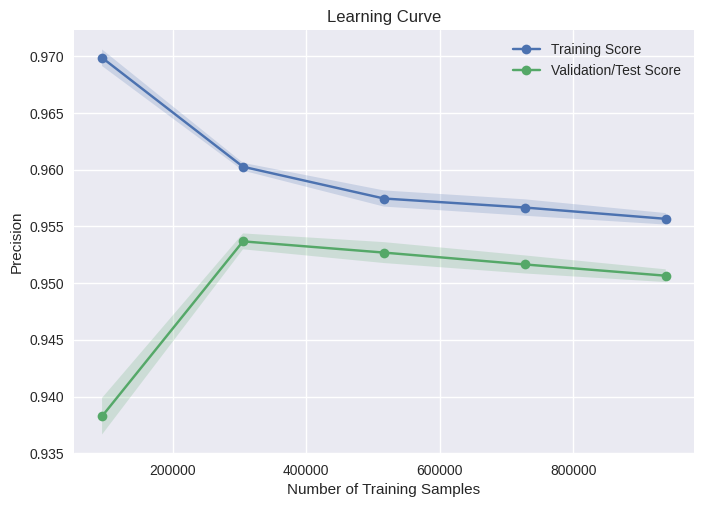

In [125]:
# Define the number of training samples to use for the learning curve
train_sizes = np.linspace(0.1, 1.0, 5)

# Calculate learning curve scores
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=pipe,
    X=X_train_first,
    y=y_train_first,
    train_sizes=train_sizes,
    cv=5,
    scoring='precision',
    n_jobs=-1
)

# Calculate mean and standard deviation of the scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes_abs, train_scores_mean, 'o-', label='Training Score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', label='Validation/Test Score')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2)
plt.xlabel('Number of Training Samples')
plt.ylabel('Precision')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

The learning curve indicates the model's score on both the training and validation sets across various sample sizes.

#### Validation Curve:
The curve has an increase in the score upto around 300000 samples when it drops a bit as more data is added. It however remains stable and does not fall of completely.

#### Training Curve:
The curve starts on a very high score for about 120000 samples but then drops to around 0.96 for 300000 samples. This may suggest that the model may have experienced overfitting. The score then drops gradually until around 0.95.

#### Overall:
The curve shows that upto some point, increasing the number of samples stops having any effect on improvement of the model's performance. This may be because the model has already captured the most relevant patterns in the data.<br>
This also shows that the model is able to generalize to unseen data.


# Review of Final Model

The model has a high `Precision` score of `0.95`. This indicates that the model is able to correctly predict `arrests` after a stop. It has a low false positive rate and it performs well in classifying instances of `arrests`.<br>

One of the main reasons this model may have performed this well is because of the feature engineering. Some features like `Officer Squad` had over `100` unique entries which were grouped together to `6` entries. Another example is `Final Call Type` which had about `160` unique entries and `Weapon Type` had over `10` unique entries. This grouping and simplification of all these features might be contributing to the high metrics in the models.<br>
